# Simple pre-processing of HEALPix output for cyclone tracking with TempestExtremes

By Alex Baker

* This takes approx. 3 hours to run for N2560 data. If you're familiar with batch processing on JASMIN, this will speed up processing time. A script is available to do this.

[Edit by Stella] Modified the number of cells to actually represent 0.2° grid. The higher number makes TempestExtremes very slow.

In [1]:
import os, intake, datetime
import xarray as xr
import numpy as np
import easygems.healpix as egh
import healpix as hp

/home/users/sbourdin/.conda/envs/hackathon/lib/python3.12/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:
# Select zoom level, variables and levels
zoom = 9
variables_1h_2d = ['psl','uas','vas']   # TempestExtremes tracking is psl-based, with surface wind maxima added to tracks
variables_3h_3d = ['zg']   # zg is used by TempestExtremes for warm-core detection and (later, optionally) computing cyclone phase-space parameters (see Stella Bourdin's code)
plevc = np.array([925,500,250])

In [3]:
cat = intake.open_catalog('https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml')['online']

In [4]:
# List UM simulations
[key for key in cat if key.startswith('um_')]

['um_Africa_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_CTC_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_SAmer_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_SEA_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_glm_n1280_CoMA9_TBv1p2',
 'um_glm_n1280_GAL9',
 'um_glm_n2560_RAL3p3']

In [5]:
# Select simulation and make an output directory (this may need to be on a group workspace or on scratch, rather than ~/)
#run = 'um_glm_n1280_GAL9'
run = 'um_glm_n2560_RAL3p3'

working_dir = '/work/scratch-nopw2/sbourdin/'
output_dir = os.path.join(working_dir,'data_pp/',run)
if not os.path.isdir(output_dir):
    os.makedirs(output_dir)

In [7]:
ds_1h_2d = cat[run](zoom=zoom, time='PT1H').to_dask()#.pipe(egh.attach_coords)
ds_3h_3d = cat[run](zoom=zoom, time='PT3H').to_dask()#.pipe(egh.attach_coords)

/home/users/sbourdin/.conda/envs/hackathon/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
/home/users/sbourdin/.conda/envs/hackathon/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


In [8]:
# Set up grid
# Find the HEALPix pixels that are closest to, for example, the .2x.2 degree grid points.
# N.B. A 1x1 has lines at lon=90, 180, 270 (need to avoid these).

#lon = np.arange(0, 360, 0.2)
#lat = np.arange(90, -91, -0.2)
lon = np.linspace(0, 360, 1800)
lat = np.linspace(90, -90, 900)

pix = xr.DataArray(
    hp.ang2pix(ds_1h_2d.crs.healpix_nside, *np.meshgrid(lon, lat), nest=True, lonlat=True),
    coords=(("lat", lat), ("lon", lon)))

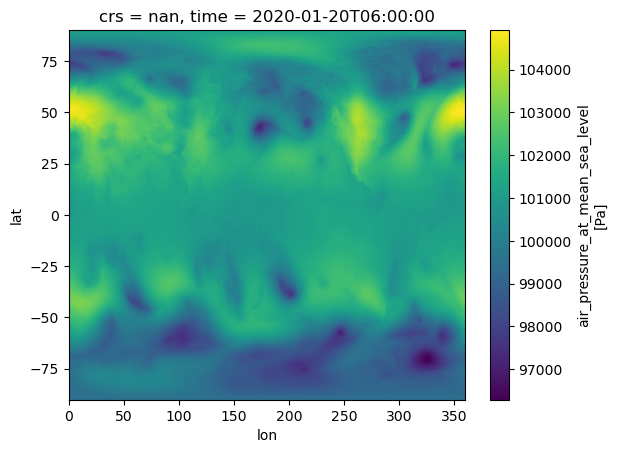

In [9]:
# Make a test plot with remapped data for a given variable and time.
ds_1h_2d.psl.sel(time="2020-01-20 06:00").isel(cell=pix).plot()

In [ ]:
%%time

# Loop over dataset, saving a file for each timestep (these can be combined later using "cdo cat...", if preferred)
date_start = str(ds_1h_2d.time[0].to_numpy())[:10]
date_end = str(ds_1h_2d.time[-2].to_numpy())[:10]
print('date start: {}'.format(date_start))
print('date end: {}'.format(date_end))

for var in variables_1h_2d:
    print(var)
    for t in ds_1h_2d.time.values[::6]:   # select 6 hourly data
        output_fn = '_'.join([run,var,str(t)[:13]])+'.nc'
        output_ffp = os.path.join(output_dir,output_fn)
        d = ds_1h_2d[var].sel(time=t).isel(cell=pix)
        d.to_netcdf(output_ffp)
        
for var in variables_3h_3d:
    print(var)
    for t in ds_3h_3d.time.values[::2]:   # select 6 hourly data
        output_fn = '_'.join([run,var,str(t)[:13]])+'.nc'
        output_ffp = os.path.join(output_dir,output_fn)
        d = ds_3h_3d[var].sel(time=t,pressure=plevc).isel(cell=pix)
        d.to_netcdf(output_ffp)